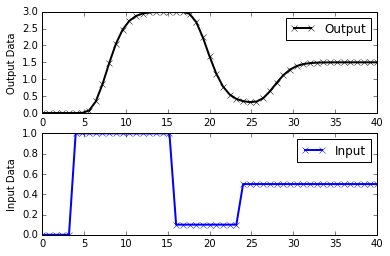

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


# define process model(to generate process data) high order model
def process(y,t,n,u,Kp,taup):
    #arguments
    #y[n]=outputs
    #t=time
    #n=order of the system
    #u=input value
    #Kp=process gain
    #taup=process time constant
    
    # equations for higner order system
    dydt = np.zeros(n)
    # calculate derivative
    dydt[0]=(-y[0]+Kp*u)/(taup/n)
    for i in range(1,n):
        dydt[i]=(-y[i]+y[i-1])/(taup/n)
    return dydt

# specify number of steps
ns = 50
# define time points
t = np.linspace(0,40,ns+1)
delta_t = t[1]-t[0]
# define input vector
u = np.zeros(ns+1)
u[5:20] = 1.0
u[20:30] = 0.1
u[30:] = 0.5

# use this function or replace yp with real process data
def sim_process_data():
    # higher order process
    n = 10   # order
    Kp = 3.0  # gain
    taup = 5.0 # time constant
    # storage for predictions or data
    yp = np.zeros(ns+1)  # process
    for i in range(1,ns+1):
        if i==1:
            yp0 = np.zeros(n)
        ts = [delta_t*(i-1),delta_t*i]
        y = odeint(process,yp0,ts,args=(n,u[i],Kp,taup))
        yp0 = y[-1]
        yp[i] = y[1][n-1]
    return yp

yp = sim_process_data()

# construct results and save data file
# column 1 = time
# column 2 = input
# column 3 = output
data = np.vstack((t,u,yp))  # vertical stack
data = data.T               # transpose data
np.savetxt('data.txt',data,delimiter=',')

# plot results
%matplotlib inline
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,yp,'kx-',linewidth=2,label='Output')
plt.ylabel('Output Data')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.legend(['Input'],loc='best')
plt.ylabel('Input Data')
plt.show()


Initial SSE Objective: 6.93180854948
     fun: 0.29704391151892884
     jac: array([ 0.00532865,  0.01287376,  0.00492799,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 60
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 3.01454485,  1.85856395,  2.93679149])
Final SSE Objective: 0.297043911519
Kp: 3.01454484756
taup: 1.85856394914
thetap: 2.9367914886


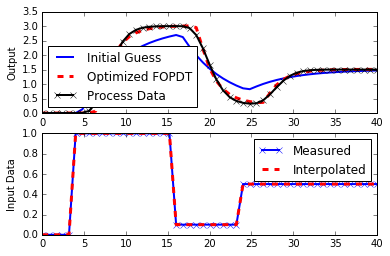

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# import csv data file
# column 1 = time (t)
# column 2 = input (u)
# column 3 = output (yp)
data = np.loadtxt('data.txt',delimiter=',')
u0 = data[0,1]
yp0 = data[0,2]
t = data[:,0].T
u = data[:,1].T
yp = data[:,2].T

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

# define first-order plus dead-time approximation
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    # y = output
    # t = time
    # uf = input linear function(for time shift)
    # Km = model gain
    # taum = model time constant
    # thetam = model time constant
    # time-shift u
    try:
        if (t-thetam)<0:
            um=uf(0.0)
        else:
            um=uf(t-thetam)
    except:
        #print('Error with time extrapolation: '+str(t))
        um=0
    dydt = (-y + Km*um)/taum
    return dydt

# simulate FOPDT model with x = [Km,taum,thetam]
def sim_model(x):
    # input_arguments
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # storage for model values
    ym = np.zeros(ns) 
    # initial condition
    ym[0] = yp0
    # loop through time steps
    for i in range(0,ns-1):
        ts = [delta_t*i,delta_t*(i+1)]
        y1 = odeint(fopdt,ym[i],ts,args=(uf,Km,taum,thetam))
        ym[i+1]=y1[-1]
    return ym

# define objective
def objective(x):
    # simulate model
    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2
    # return result
    return obj

# initial guesses
x0 = np.zeros(3)
x0[0]= 3 # Km
x0[1]= 5 # taum
x0[2]= 1 # thetam

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))

# optimize Km,taum,thetam
# bounds on variables
bnds = ((-1.0e10,1.0e10),(0.01,1.0e10),(0.0,1.0e10))
solution = minimize(objective, x0,method='SLSQP',bounds=bnds)
print(solution)
x = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(x)))

print('Kp: ' + str(x[0]))
print('taup: ' + str(x[1]))
print('thetap: ' + str(x[2]))

# calculate model with updated parameters
ym1 = sim_model(x0)
ym2 = sim_model(x)
# plot results
%matplotlib inline
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
plt.plot(t,ym2,'r--',linewidth=3,label='Optimized FOPDT')
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.show()
    
    